In [2]:
%matplotlib inline

In [3]:
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
from torch.autograd import Variable
import time

In [24]:

log_data_paths = ["/work/pfeiffer/training/market1501_train_BatchHard-soft_18-4_0.000300_25000/log.h5",
                 "/work/pfeiffer/training/duke_mtmc_reid_train_BatchHard-soft_18-4_0.000300_25000/log.h5",
                 "/work/pfeiffer/training/duke_mtmc_reid_train_BatchSoft-soft-0.800000-soft_18-4_0.000300_25000/log.h5"]


In [25]:
log_data = [(h5py.File(path), path) for path in log_data_paths]

In [26]:
def show_loss(log_data, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7), 
                                        sharey=True)
    fig.suptitle(title)
    x = np.arange(0, len(log_data["log"]))
    ax1.plot(x, log_data["log"][:, 0])
    ax1.set_title('min loss')
    ax2.plot(x, log_data["log"][:, 1])
    ax2.set_title('mean loss')
    ax3.plot(x, log_data["log"][:, 2])
    ax3.set_title('max loss')

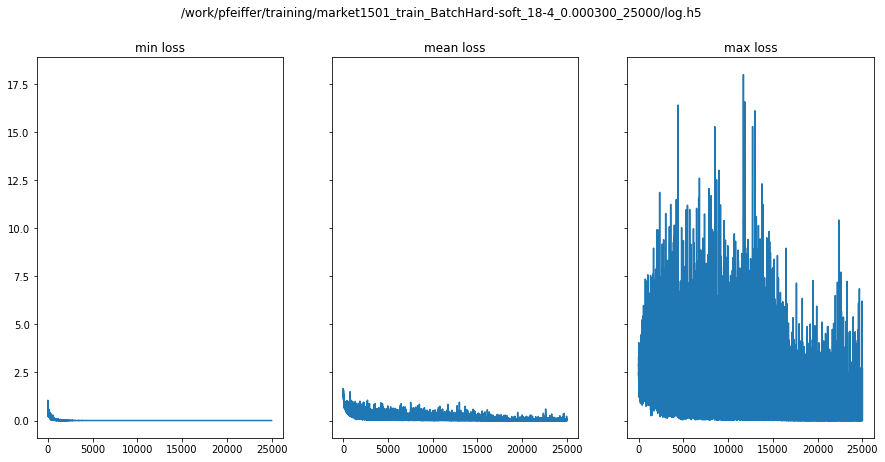

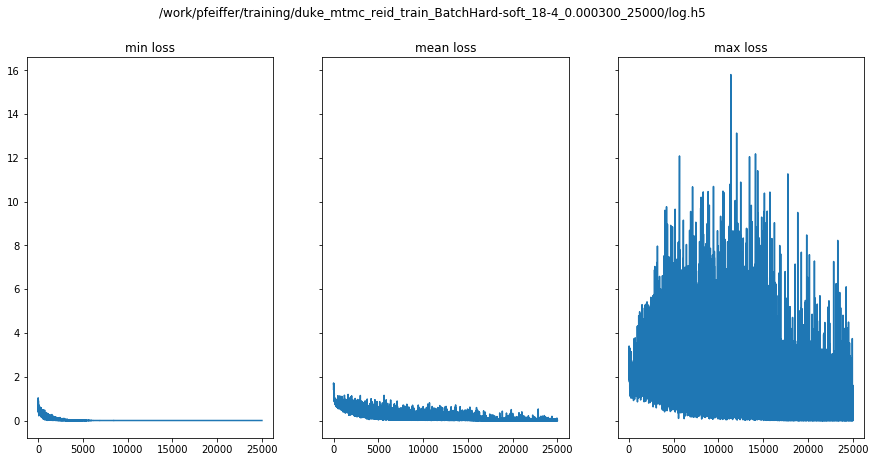

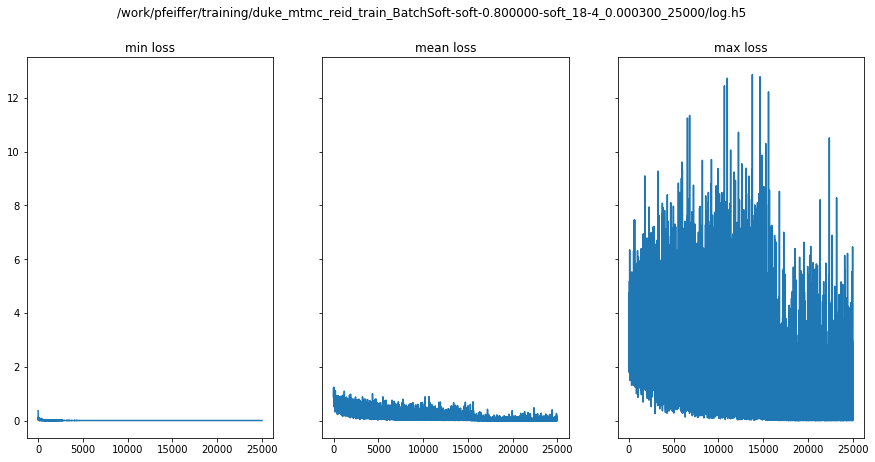

In [27]:
for data, title in log_data:
    show_loss(data, title)

In [28]:
def show_top(log_data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), 
                                   sharey=True)
    fig.suptitle(title)
    x = np.arange(0, len(log_data["log"]))
    ax1.plot(x, log_data["log"][:, 4])
    ax1.set_title('top-1')
    ax2.plot(x, log_data["log"][:, 5])
    ax2.set_title('top-5')


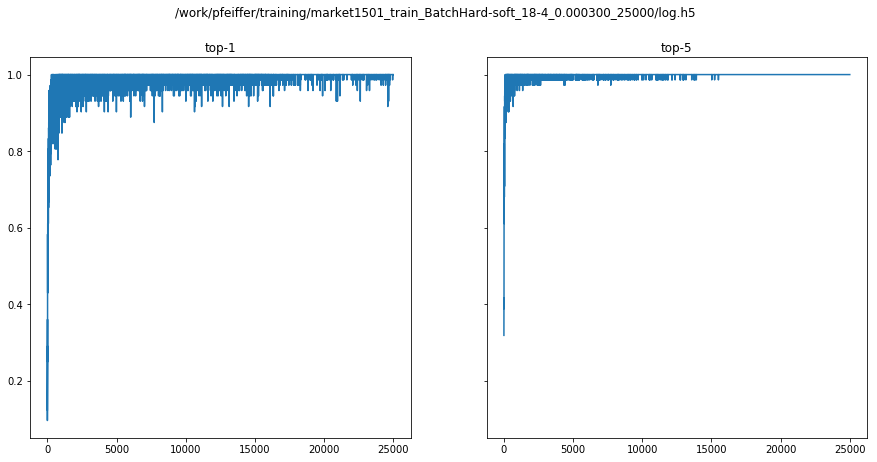

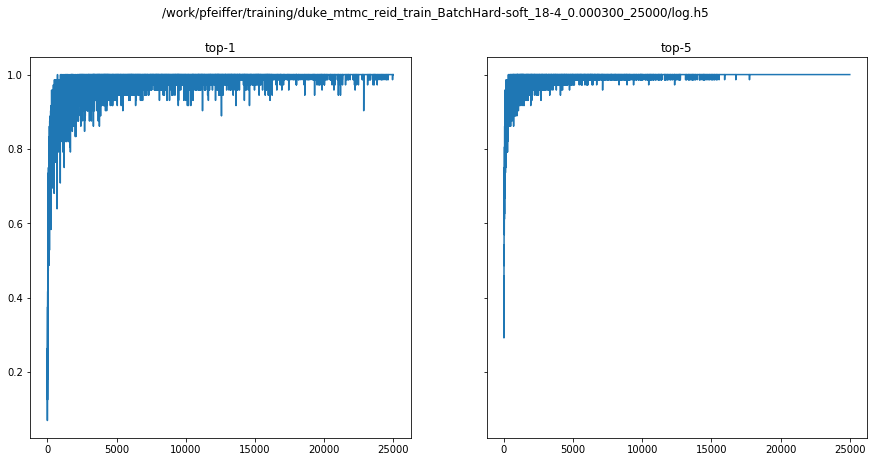

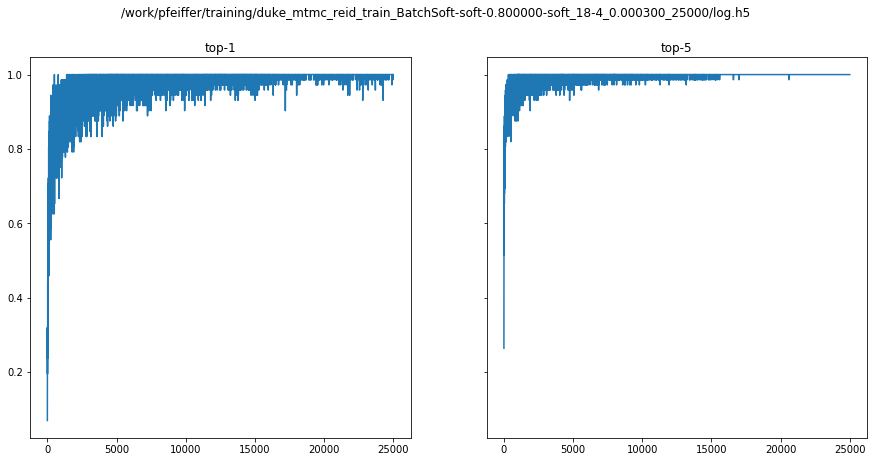

In [29]:
for data, title in log_data:
    show_top(data, title)

In [40]:
import matplotlib.image as mpimg
def show_triplet(anchor, positive, negative):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
    
    anchor = mpimg.imread(anchor)
    ax1.set_title('anchor')
    ax1.imshow(anchor)
    
    positive = mpimg.imread(anchor)
    ax2.set_title('positive')
    ax2.imshow(positive)
    
    negative = mpimg.imread(negative)
    ax3.set_title('negative')
    ax3.imshow(negative)

In [10]:
from triplet_loss import calc_cdist

In [11]:
from triplet_loss import BatchHard

In [13]:
import pyro
softmax = torch.nn.Softmax()
softmin = torch.nn.Softmin()
def batch_soft(cdist, pids, margin, T=None):
    global softmax, softmin
    # mask where all positivies are set to true
    mask_pos = pids[None, :] == pids[:, None]
    mask_neg = 1 - mask_pos.data
    
    # only one copy
    cdist_max = cdist.clone()
    cdist_max[mask_neg] = -np.inf 
    
    cdist_min = cdist
    cdist_min[mask_pos] = np.inf
    
    
    if T is None:
        idx_pos = pyro.distributions.categorical(softmax(cdist_max))
        idx_neg = pyro.distributions.categorical(softmin(cdist_min))
    else:
        idx_pos = pyro.distributions.categorical(softmax(cdist_max/T))
        idx_neg = pyro.distributions.categorical(softmin(cdist_min/T))
    max_pos = cdist_max.masked_select(idx_pos.byte())
    min_neg = cdist_min.masked_select(idx_neg.byte())
    return max_pos - min_neg, idx_pos, idx_neg

In [19]:

def number_of_active_triplets(data, margin, title, start=0, end=None):
    active_soft = []
    active_hard = []
    idxs = []
    batch_hard = BatchHard(margin)
    if end is None:
        end = len(data["emb"])
    for idx in range(start, end):
        
        emb = Variable(torch.FloatTensor(data["emb"][idx]))
        pids = Variable(torch.LongTensor(data["pids"][idx]))
        
        #file = hfile["file"][idx]
        idxs.append(idx)
        cdist = calc_cdist(emb, emb)
        start = time.time()
        diff_hard = batch_hard(cdist, pids)
        diff_soft, _, _ = batch_soft(cdist, pids, margin)
        
        a_h = torch.sum(diff_hard > 0).data.numpy()[0]
        a_s = torch.sum(diff_soft > 0).data.numpy()[0]
        active_hard.append(a_h)
        active_soft.append(a_s)
        
        print("\rFinished Batch %06d/%d Took %fs" % (idx, end, (time.time() - start)), flush=True, end='')
        if end is not None and idx > end:
            break
        
            
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    fig.suptitle(title)
    ax1.set_title('#Actives (Soft margin)')
    ax1.plot(idxs, active_soft)
    ax2.set_title('#Actives (Hard margin)')
    ax2.plot(idxs, active_hard)

Finished Batch 024999/25000 Took 0.003842s

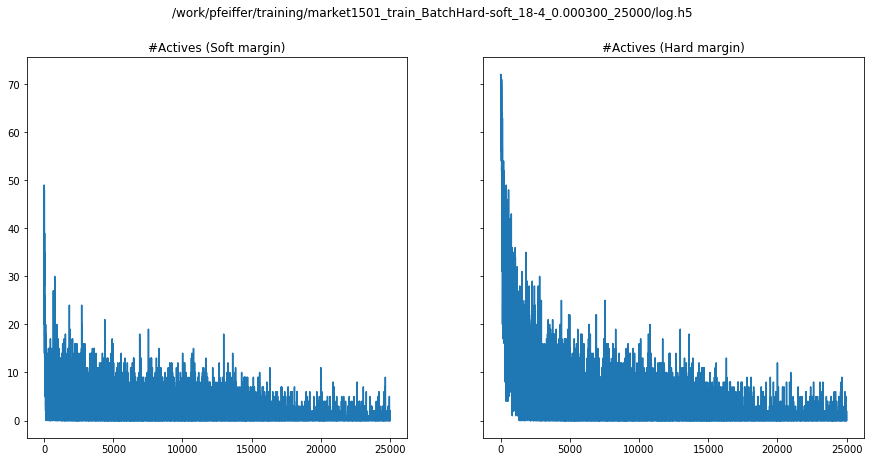

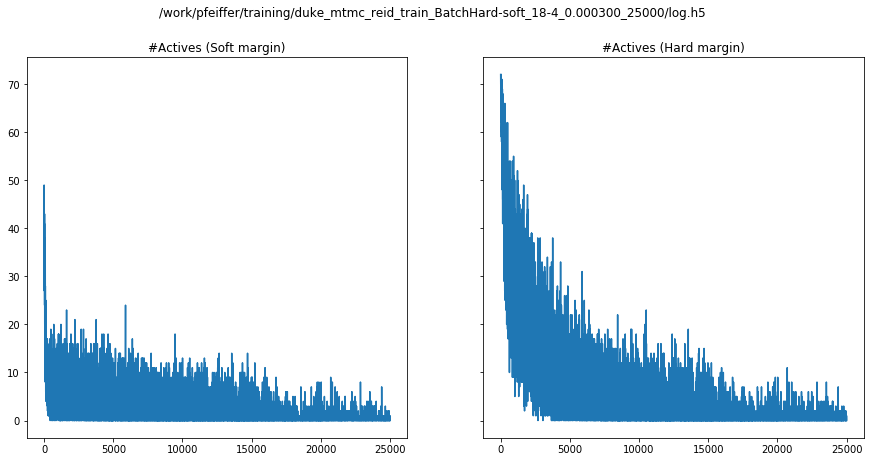

In [164]:
for data, title in log_data:
    number_of_active_triplets(data, "none", title)

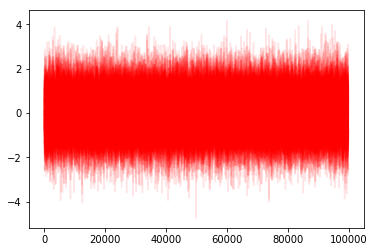

In [176]:
for i in range(200):
    plt.plot(x[i::200], y[i::200], alpha=0.1, color='r')

In [241]:
ln2 = Variable(torch.log(torch.Tensor([2])))
def log2(x):
    return torch.log(x + 1e-12) / ln2 #numerical stability

In [242]:
def calc_entropy(distr):
    return -torch.sum(distr * log2(distr), dim=1)
    

In [243]:
distr = Variable(torch.Tensor([[0.25, 0.25, 0.25, 0.25], [0.5, 0.5, 0.0, 0.0]]))
entropy = calc_entropy(distr)
entropy.mean()[0]

Variable containing:
 1.5000
[torch.FloatTensor of size 1]

In [6]:
import time
def entropy(data, start=0, end=None):
    start_time = time.time()
    entropies_pos = []
    entropies_neg = []
    idxs = []
    if end is None:
        end = len(data["emb"])
    for idx in range(start, end):
        emb = Variable(torch.FloatTensor(data["emb"][idx]))
        pids = Variable(torch.LongTensor(data["pids"][idx]))
        cdist = calc_cdist(emb, emb)
        
        mask_pos = pids[None, :] == pids[:, None]
        mask_neg = 1 - mask_pos.data
        
        # only one copy
        cdist_max = cdist.clone()
        cdist_max[mask_neg] = -np.inf 

        cdist_min = cdist
        cdist_min[mask_pos] = np.inf
        
        distr_pos = softmax(cdist_max)
        distr_neg = softmin(cdist_min)
        
        entropy_pos = calc_entropy(distr_pos)
        entropy_neg = calc_entropy(distr_neg)
        
        entropies_pos.append(entropy_pos.mean().data[0])
        entropies_neg.append(entropy_neg.mean().data[0])
        
        idxs.append(idx)
        print("\rFinished Batch %06d/%d Took %fs" % (idx, end, (time.time() - start_time)), flush=True, end='')
        if idx >= end:
            break
    return idxs, entropies_pos, entropies_neg
        

In [252]:
def draw_chart(indices, datas, title, axtitles):
    fig, axis = plt.subplots(1, len(datas), figsize=(15, 7), sharey=True)
    fig.suptitle(title)
    for idx, ax in enumerate(axis):
        ax.set_title(axtitles[idx])
        ax.plot(indices[idx], datas[idx])

In [253]:
entropy_data = []
for data, _ in log_data:
    idxs, entropies_pos, entropies_neg = entropy(data)
    entropy_data.append((idxs, entropies_pos, entropies_neg))
    

Finished Batch 024999/25000 Took 94.314629s

In [312]:
np.log2(72)

6.1699250014423122

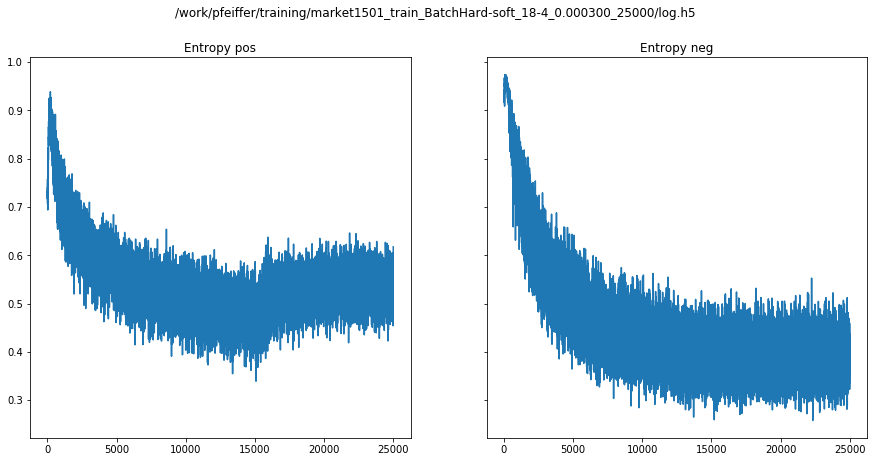

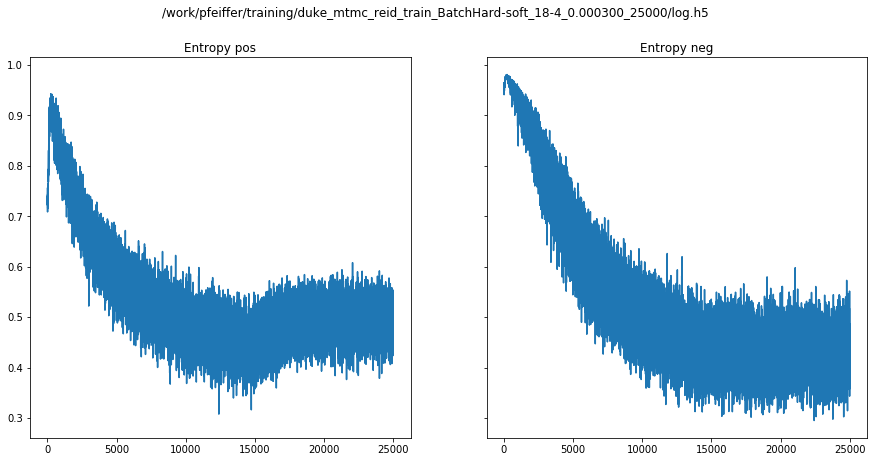

In [314]:
for idx, (_, title) in enumerate(log_data):
    idxs, entropies_pos, entropies_neg = entropy_data[idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    fig.suptitle(title)
    ax1.set_title('Entropy pos')
    ax1.plot(idxs, entropies_pos/np.log2(4))
    ax2.set_title('Entropy neg')
    ax2.plot(idxs, entropies_neg/np.log2(72))

In [15]:
from ipywidgets import interact, interactive
import ipywidgets as widgets
@interact(
    batch=widgets.IntSlider(min=0, max=25000, step=1000, continuous_update=False)
)
def _show_probability_distribution(batch):
    for data, title in log_data:
        emb = torch.FloatTensor(data["emb"][batch])
        pids = torch.LongTensor(data["pids"][batch])
        cdist = calc_cdist(emb, emb)

        mask_same = pids[None, :] == pids[:, None]
        mask_neg = 1 - mask_same

        # only one copy
        cdist_max = cdist.clone()
        cdist_max[mask_neg + torch.eye(len(pids)).byte()] = -np.inf

        cdist_min = cdist
        cdist_min[mask_same] = np.inf

        distr_pos = softmax(cdist_max/0.2)
        distr_neg = softmax(-cdist_min/0.2)

        probs_pos = np.sort(distr_pos.data.numpy()).mean(axis=0)
        probs_neg = np.sort(distr_neg.data.numpy()).mean(axis=0)
        
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
        fig.suptitle(title)
        ax1.set_title('#Distr neg')
        ax1.bar(np.arange(72), probs_neg)
        ax1.set_ylim([0.0, 1.0])
        ax2.set_title('#Distr pos')
        ax2.bar(np.arange(72), probs_pos)
        ax2.set_ylim([0.0, 1.0])
        plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='batch', max=25000, step=1000), Output()), _dom_classes=('widget-interact',))

In [400]:
for idx1, batch in enumerate(data["file"]):
        for idx2, file in enumerate(batch):
            batch[idx2] = file.replace("datasets/Market-1501/bounding_box_train/", "")
        data["file"][idx1] = batch

In [26]:
import time
def count_triplets(data, margin, start=0, end=None):
    start_time = time.time()
    idxs = []
    triplets = {}
    #sampled in batch
    sampled = {}
    # chosen as argmax or argmin
    picked = {}
    # actually used for loss
    used = {}
    if end is None:
        end = len(data["emb"])
    for idx in range(start, end):
        
        emb = Variable(torch.FloatTensor(data["emb"][idx]))
        pids = Variable(torch.LongTensor(data["pids"][idx]))
        file = data["file"][idx]
        
        #file = hfile["file"][idx]
        idxs.append(idx)
        cdist = calc_cdist(emb, emb)
        
        diff_soft, idx_pos, idx_neg = batch_soft(cdist, pids, margin)
        idx_pos = idx_pos.data.numpy() > 0
        idx_neg = idx_neg.data.numpy() > 0
        selected_pos = np.tile(file, (len(emb), 1))[idx_pos]
        selected_neg = np.tile(file, (len(emb), 1))[idx_neg]
        used_pos = selected_pos[diff_soft.data.numpy() > 0]
        used_neg = selected_neg[diff_soft.data.numpy() > 0]
        
        
        for f in file:
            if f in sampled:
                sampled[f] += 1
            else:
                sampled[f] = 1
        
        for pos in selected_pos:
            if pos in picked:
                picked[pos] += 1
            else:
                picked[pos] = 1
        
        for neg in selected_neg:
            if neg in picked:
                picked[neg] += 1
            else:
                picked[neg] = 1
                
        for pos in used_pos:
            if pos in used:
                used[pos] += 1
            else:
                used[pos] = 1
                
        for neg in used_neg:
            if neg in used:
                used[neg] += 1
            else:
                used[neg] = 1
         
        
        
        #triplet_names = file + selected_pos + selected_neg
        #for triplet in triplet_names:
        #    if triplet in triplets:
        #        triplets[triplet] += 1
        #    else:
        #        triplets[triplet] = 1
        
        print("\rFinished Batch %06d/%d Took %fs" % (idx, end, (time.time() - start_time)), flush=True, end='')
        if end is not None and idx > end:
            break   
    return triplets, sampled, picked, used

In [57]:
count_sample_data = []
for data, title in log_data:
    count_sample_data.append(count_triplets(data, 0))

Finished Batch 024999/25000 Took 163.776916s

In [38]:
def dic2array(dic):
    return np.asarray(list(dic.values()))

In [44]:
print(np.max(dic2array(sampled)))

1212


In [69]:
import matplotlib.image as mpimg
def show_image(path):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    fig.suptitle(path)
    anchor = mpimg.imread(path)
    ax1.set_title('anchor')
    ax1.imshow(anchor)

In [72]:
def count_distribution(samples, picked, used):
    uses_per_sample = {}
    picks_per_sample = {}
    for sample, value in samples.items():
        #print("Sample: %s" % sample)
        if sample in used:
            uses = used[sample]
        else:
            uses = 0
        
        if sample in picked:
            picks = picked[sample]
        else:
            show_image(sample)
            picks = 0
        # print("%d/%d" % (uses, value))
        uses_per_sample[sample] = (uses/value)
        picks_per_sample[sample] = (picks/value)
    return uses_per_sample, picks_per_sample

2690 184
0.0535417195381 0.0562237439446 2.01084171694 0.559942798032
0.0 1.64150943396 0.768595041322 6.31481481481
20880 95
0.0713777409206 0.0906927680175 2.04231118247 0.696739767798
0.0 2.0 0.0 11.5


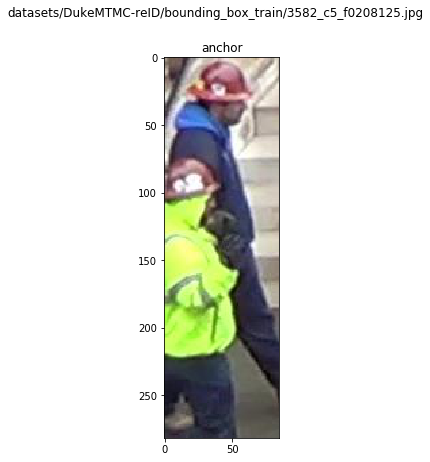

In [78]:
for _, sampled, picked, used in count_sample_data:
    uses_per_sample, picks_per_sample = count_distribution(sampled, picked, used)
    picked_array = dic2array(picked)
    used_array = dic2array(used)
    print(np.max(picked_array), np.max(used_array))
    uses_array = dic2array(uses_per_sample)
    picks_array = dic2array(picks_per_sample)
    print(np.mean(uses_array), np.std(uses_array), np.mean(picks_array), np.std(picks_array))
    print(np.min(uses_array), np.max(uses_array), np.min(picks_array), np.max(picks_array))

In [87]:
def find_value(value, dic):
    results = []
    for key, val in dic.items():
        print(key,val)
        if value == val:
            results.append(key)
    return results

In [95]:
results = find_value(184, count_sample_data[1][3])

datasets/DukeMTMC-reID/bounding_box_train/0402_c6_f0092575.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/0073_c2_f0069789.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0679_c1_f0170102.jpg 21
datasets/DukeMTMC-reID/bounding_box_train/0679_c8_f0133285.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0679_c8_f0132805.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0720_c1_f0182442.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0600_c5_f0165708.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/0600_c6_f0144003.jpg 23
datasets/DukeMTMC-reID/bounding_box_train/1760_c4_f0124463.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/1760_c4_f0124103.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/1760_c4_f0123983.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4751_c8_f0153747.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/4355_c8_f0062513.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/4355_c6_f0083392.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/3555_c5_f0122071.jpg 6
datasets/DukeMTMC-re

datasets/DukeMTMC-reID/bounding_box_train/0328_c1_f0105836.jpg 21
datasets/DukeMTMC-reID/bounding_box_train/0328_c6_f0093414.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/0855_c2_f0221754.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0855_c2_f0221634.jpg 16
datasets/DukeMTMC-reID/bounding_box_train/2770_c5_f0206518.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/2770_c5_f0222281.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/2770_c4_f0172280.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0245_c8_f0051762.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0245_c8_f0051882.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0465_c1_f0124917.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0465_c6_f0103836.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/0349_c1_f0107427.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0349_c2_f0106266.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0557_c2_f0152755.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0081_c1_f0067597.jpg 27
datasets/DukeMTMC-re

datasets/DukeMTMC-reID/bounding_box_train/0817_c2_f0206156.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0784_c2_f0214446.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/3716_c5_f0185452.jpg 17
datasets/DukeMTMC-reID/bounding_box_train/0697_c1_f0173614.jpg 13
datasets/DukeMTMC-reID/bounding_box_train/3716_c8_f0140344.jpg 19
datasets/DukeMTMC-reID/bounding_box_train/0550_c1_f0141701.jpg 34
datasets/DukeMTMC-reID/bounding_box_train/4527_c6_f0117280.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0613_c4_f0139066.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0157_c5_f0085137.jpg 16
datasets/DukeMTMC-reID/bounding_box_train/0569_c4_f0130026.jpg 47
datasets/DukeMTMC-reID/bounding_box_train/0411_c6_f0094581.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/4513_c6_f0111880.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/0483_c2_f0131944.jpg 16
datasets/DukeMTMC-reID/bounding_box_train/0017_c8_f0011001.jpg 14
datasets/DukeMTMC-reID/bounding_box_train/4515_c7_f0116100.jpg 12
datasets/DukeM

datasets/DukeMTMC-reID/bounding_box_train/0217_c2_f0091701.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/0156_c4_f0062413.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0156_c1_f0082785.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/1874_c6_f0155378.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0645_c2_f0163516.jpg 22
datasets/DukeMTMC-reID/bounding_box_train/0645_c2_f0163156.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0645_c2_f0163276.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/4501_c6_f0108886.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/0198_c2_f0089044.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/1358_c4_f0048863.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0217_c1_f0091717.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/0156_c2_f0087594.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/4684_c6_f0156659.jpg 49
datasets/DukeMTMC-reID/bounding_box_train/4667_c7_f0155418.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4684_c6_f0156419.jpg 9
datasets/DukeMTMC-reI

datasets/DukeMTMC-reID/bounding_box_train/0392_c6_f0089983.jpg 9
datasets/DukeMTMC-reID/bounding_box_train/0397_c1_f0112343.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0671_c1_f0169289.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/4481_c6_f0104519.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/4136_c7_f0054530.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/4136_c8_f0028294.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0236_c1_f0094377.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0730_c4_f0162624.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0308_c3_f0076544.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0154_c1_f0081752.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4263_c6_f0071025.jpg 14
datasets/DukeMTMC-reID/bounding_box_train/0074_c1_f0064616.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/4624_c6_f0144783.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0619_c4_f0138866.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/0619_c2_f0163736.jpg 10
datasets/DukeMTMC-reID

datasets/DukeMTMC-reID/bounding_box_train/0421_c6_f0096455.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/4679_c6_f0155182.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0657_c6_f0153916.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/2421_c8_f0016537.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/1358_c3_f0056068.jpg 14
datasets/DukeMTMC-reID/bounding_box_train/0534_c7_f0119462.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/3758_c8_f0158421.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0520_c4_f0112120.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/2770_c4_f0171920.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0271_c1_f0097041.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/0640_c4_f0145257.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/4216_c6_f0063794.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0191_c2_f0092216.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/0719_c1_f0181222.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/0719_c3_f0156811.jpg 21
datasets/DukeMTM

datasets/DukeMTMC-reID/bounding_box_train/0463_c3_f0106475.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0547_c1_f0141242.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0001_c6_f0030689.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0022_c1_f0052181.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0001_c5_f0051847.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4211_c7_f0065171.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0022_c2_f0056541.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/0796_c1_f0203493.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0511_c2_f0131720.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/0396_c6_f0100076.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/0796_c3_f0178236.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0730_c1_f0182841.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0730_c1_f0183321.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4492_c7_f0110052.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0440_c2_f0120408.jpg 7
datasets/DukeMTMC-reID/

datasets/DukeMTMC-reID/bounding_box_train/4211_c6_f0062491.jpg 13
datasets/DukeMTMC-reID/bounding_box_train/0837_c2_f0216152.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/4551_c6_f0124300.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0546_c4_f0120478.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0778_c3_f0176316.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/5388_c6_f0054065.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/5388_c6_f0174778.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/4481_c8_f0078075.jpg 13
datasets/DukeMTMC-reID/bounding_box_train/0203_c2_f0087625.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/4362_c6_f0084928.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/0236_c1_f0094617.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/1358_c2_f0080777.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0670_c2_f0173035.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0138_c1_f0078158.jpg 16
datasets/DukeMTMC-reID/bounding_box_train/0797_c8_f0159680.jpg 7
datasets/DukeMTMC-re

datasets/DukeMTMC-reID/bounding_box_train/1631_c3_f0098658.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/4512_c7_f0114306.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0401_c2_f0114054.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/4180_c6_f0057788.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0074_c1_f0064496.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0579_c6_f0130945.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/2432_c5_f0072365.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0445_c1_f0121287.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/1587_c3_f0090661.jpg 11
datasets/DukeMTMC-reID/bounding_box_train/1716_c8_f0099136.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0607_c5_f0168019.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0662_c2_f0166908.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/4277_c8_f0051338.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0398_c1_f0113232.jpg 12
datasets/DukeMTMC-reID/bounding_box_train/0020_c8_f0008528.jpg 5
datasets/DukeMTMC-reID/

datasets/DukeMTMC-reID/bounding_box_train/0713_c2_f0177932.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/4278_c7_f0075780.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0544_c3_f0116706.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/2597_c3_f0094446.jpg 8
datasets/DukeMTMC-reID/bounding_box_train/2597_c6_f0103809.jpg 10
datasets/DukeMTMC-reID/bounding_box_train/0121_c4_f0044859.jpg 13
datasets/DukeMTMC-reID/bounding_box_train/0478_c1_f0126021.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0511_c2_f0131240.jpg 14
datasets/DukeMTMC-reID/bounding_box_train/0844_c6_f0190502.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0013_c1_f0048386.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0844_c1_f0218704.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/1794_c4_f0133802.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/4111_c6_f0045738.jpg 5
datasets/DukeMTMC-reID/bounding_box_train/0165_c5_f0079452.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/4537_c7_f0122130.jpg 7
datasets/DukeMTMC-reID

datasets/DukeMTMC-reID/bounding_box_train/4451_c6_f0099124.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/2597_c3_f0093726.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/5388_c6_f0100061.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/0564_c2_f0149896.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0325_c1_f0105299.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/1786_c2_f0156140.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/0179_c2_f0086476.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/4104_c8_f0018545.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0153_c1_f0082289.jpg 7
datasets/DukeMTMC-reID/bounding_box_train/0510_c4_f0110746.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0384_c3_f0091995.jpg 6
datasets/DukeMTMC-reID/bounding_box_train/0339_c6_f0084957.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0330_c6_f0083505.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/4740_c7_f0175896.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/0020_c6_f0030652.jpg 3
datasets/DukeMTMC-reID/bo

datasets/DukeMTMC-reID/bounding_box_train/0165_c1_f0084222.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/0848_c1_f0218588.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/3732_c6_f0177296.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0014_c2_f0052944.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0029_c5_f0057373.jpg 4
datasets/DukeMTMC-reID/bounding_box_train/0024_c2_f0057351.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/0330_c1_f0105648.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/0202_c2_f0088415.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/4393_c6_f0088805.jpg 2
datasets/DukeMTMC-reID/bounding_box_train/4432_c6_f0096370.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/3765_c6_f0043221.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/4115_c8_f0024583.jpg 3
datasets/DukeMTMC-reID/bounding_box_train/0339_c6_f0084597.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/5388_c6_f0145604.jpg 1
datasets/DukeMTMC-reID/bounding_box_train/5388_c6_f0099821.jpg 2
datasets/DukeMTMC-reID/bo

['0940_c6s2_112243_06.jpg']


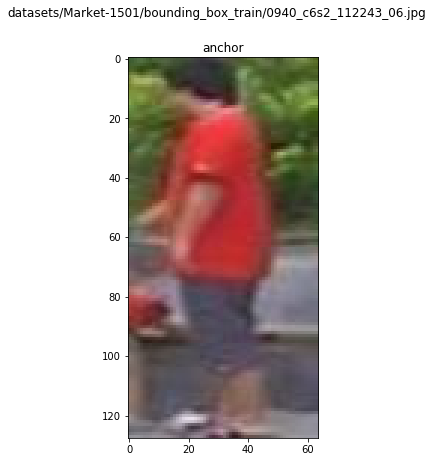

In [94]:
print(results)
for result in results:
    show_image("datasets/Market-1501/bounding_box_train/" + result)
